In [1]:
from rosa import GeneAnnDataModule
import pickle
import numpy as np

TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_with_embeds_new_norm.h5ad"
TABULA_SAPIENS_BY_CELL_TYPE_RIDGE_MODEL = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_ridge_model_new_norm.sav" # model_shuffle.sav

dm = GeneAnnDataModule(TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT)
dm.setup()

adata = dm.predict_dataset.adata
X_predict = dm.predict_dataset.gene_embedding
model = pickle.load(open(TABULA_SAPIENS_BY_CELL_TYPE_RIDGE_MODEL, 'rb'))

model

Global seed set to 0
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


Ridge(alpha=100)

In [2]:
adata.layers['prediction'] = model.predict(X_predict).T

In [3]:
from rosa.score import score_predictions
from rosa.plotting import plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)


        mean pearsonr across genes 0.658
        mean pearsonr across cells 0.412
        mean square error 0.543
        ks-statistic on total expression 0.229
        mean percent total expression captured per cell 50.499
        


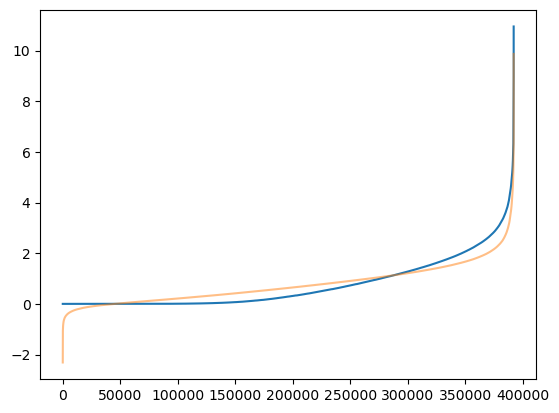

In [10]:
import matplotlib.pyplot as plt

X_meas = adata_test.X
X_pred = adata_test.layers["prediction"]

plt.plot(np.sort(X_meas.ravel()));
plt.plot(np.sort(X_pred.ravel()), alpha=0.5);


In [13]:
X_meas[X_meas>0].min()

4.2672873e-05

In [37]:
adata_test.varm['embedding'].shape

(5854, 3072)

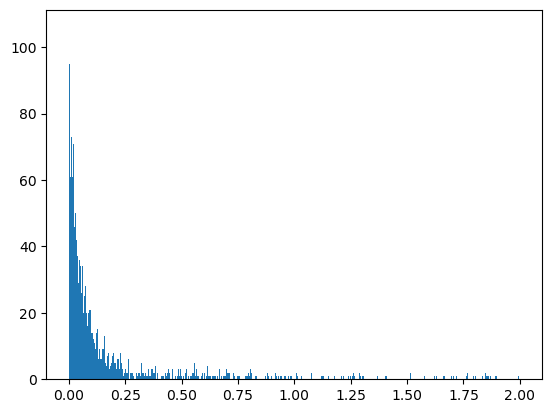

In [36]:
plt.hist(adata_test.varm['embedding'].var(axis=0), bins=np.linspace(0, 2, 1000));

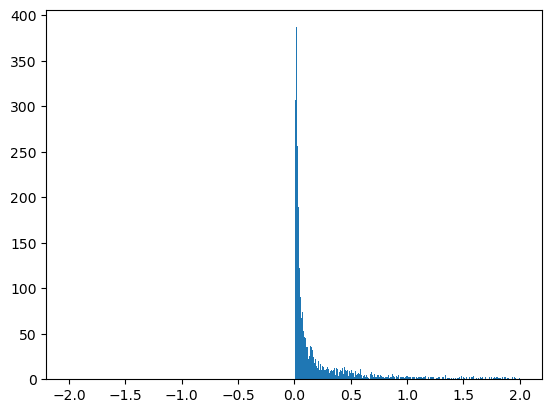

In [39]:
plt.hist(adata_test.varm['embedding'].var(axis=1), bins=np.linspace(-2, 2, 1000));

(-2.5, 2.5)

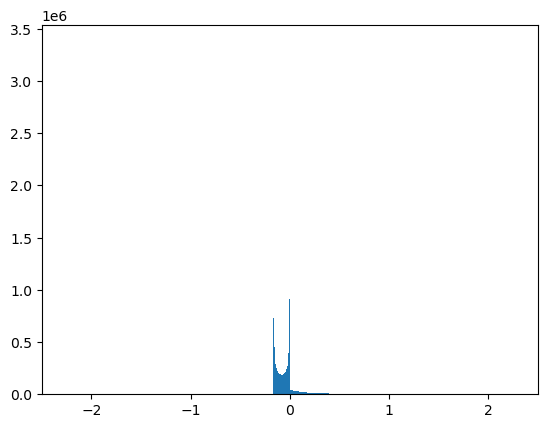

In [42]:
plt.hist(adata_test.varm['embedding'].ravel(), bins=np.linspace(-2, 2, 1000));
plt.xlim([-2.5, 2.5])

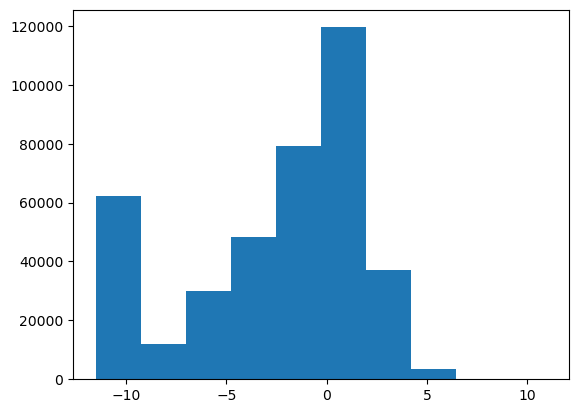

In [19]:
plt.hist(np.log(np.expm1(X_meas.ravel() + 1e-5)));

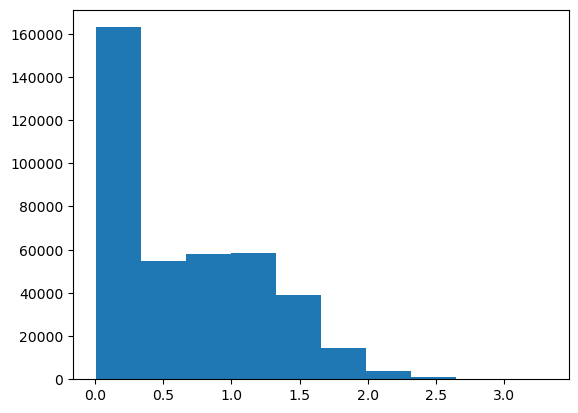

In [16]:
plt.hist(np.sqrt(X_meas.ravel() + 1e-5));

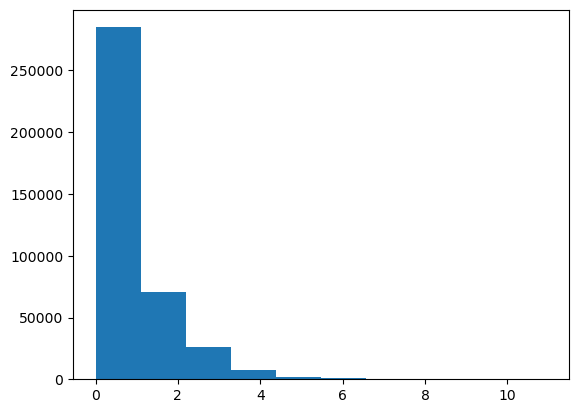

In [43]:
plt.hist(X_meas.ravel(), bins=10);

In [50]:
a = np.quantile(X_meas.ravel(), np.linspace(0, 1, 10));

In [51]:
a

array([0.00000000e+00, 0.00000000e+00, 2.69176764e-03, 3.02129574e-02,
       1.58257922e-01, 4.43562975e-01, 8.42784464e-01, 1.33788133e+00,
       2.03301907e+00, 1.09484892e+01])

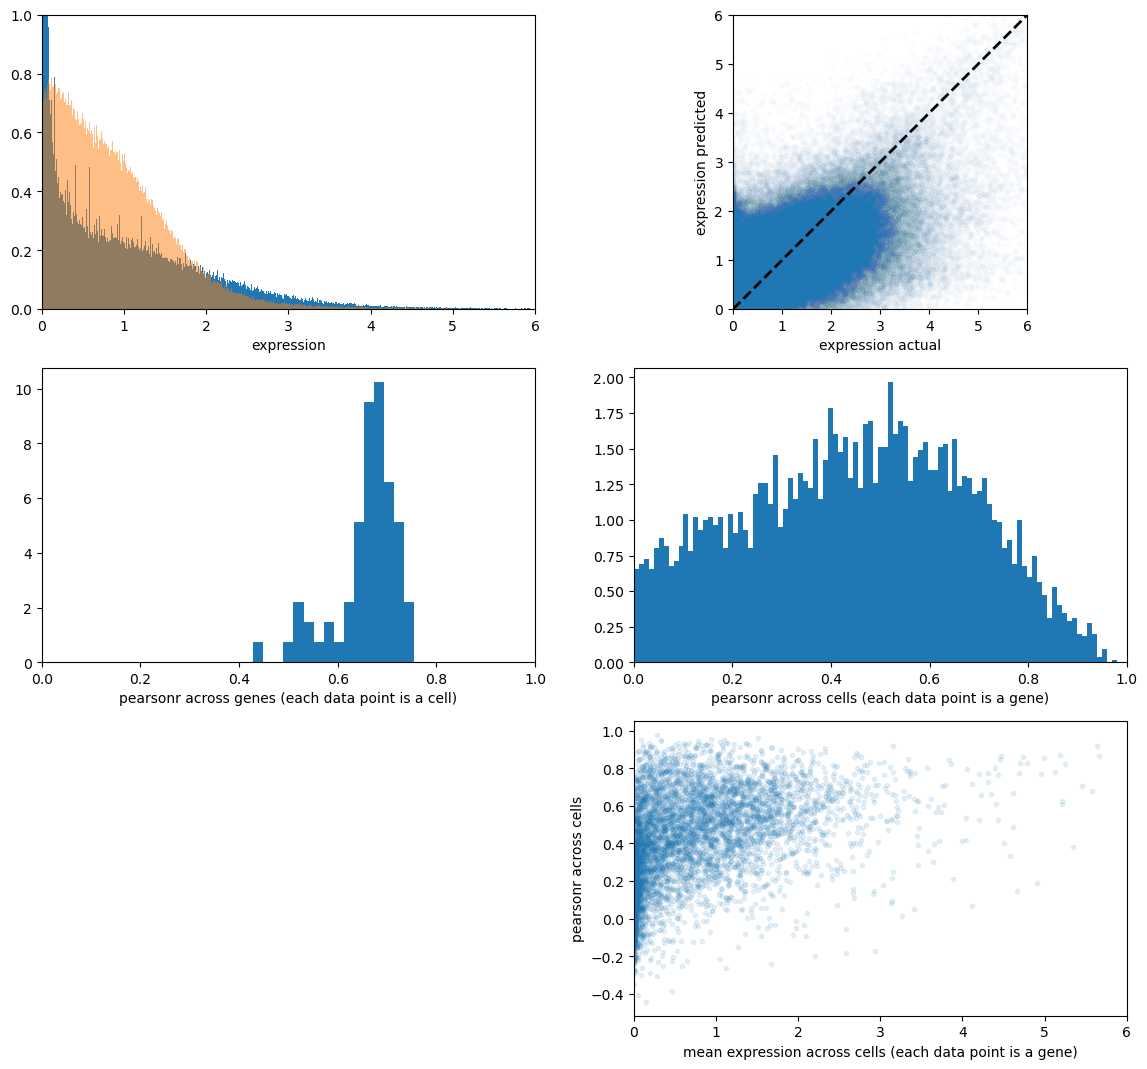

In [4]:
plot_expression_and_correlation(adata_test, results)

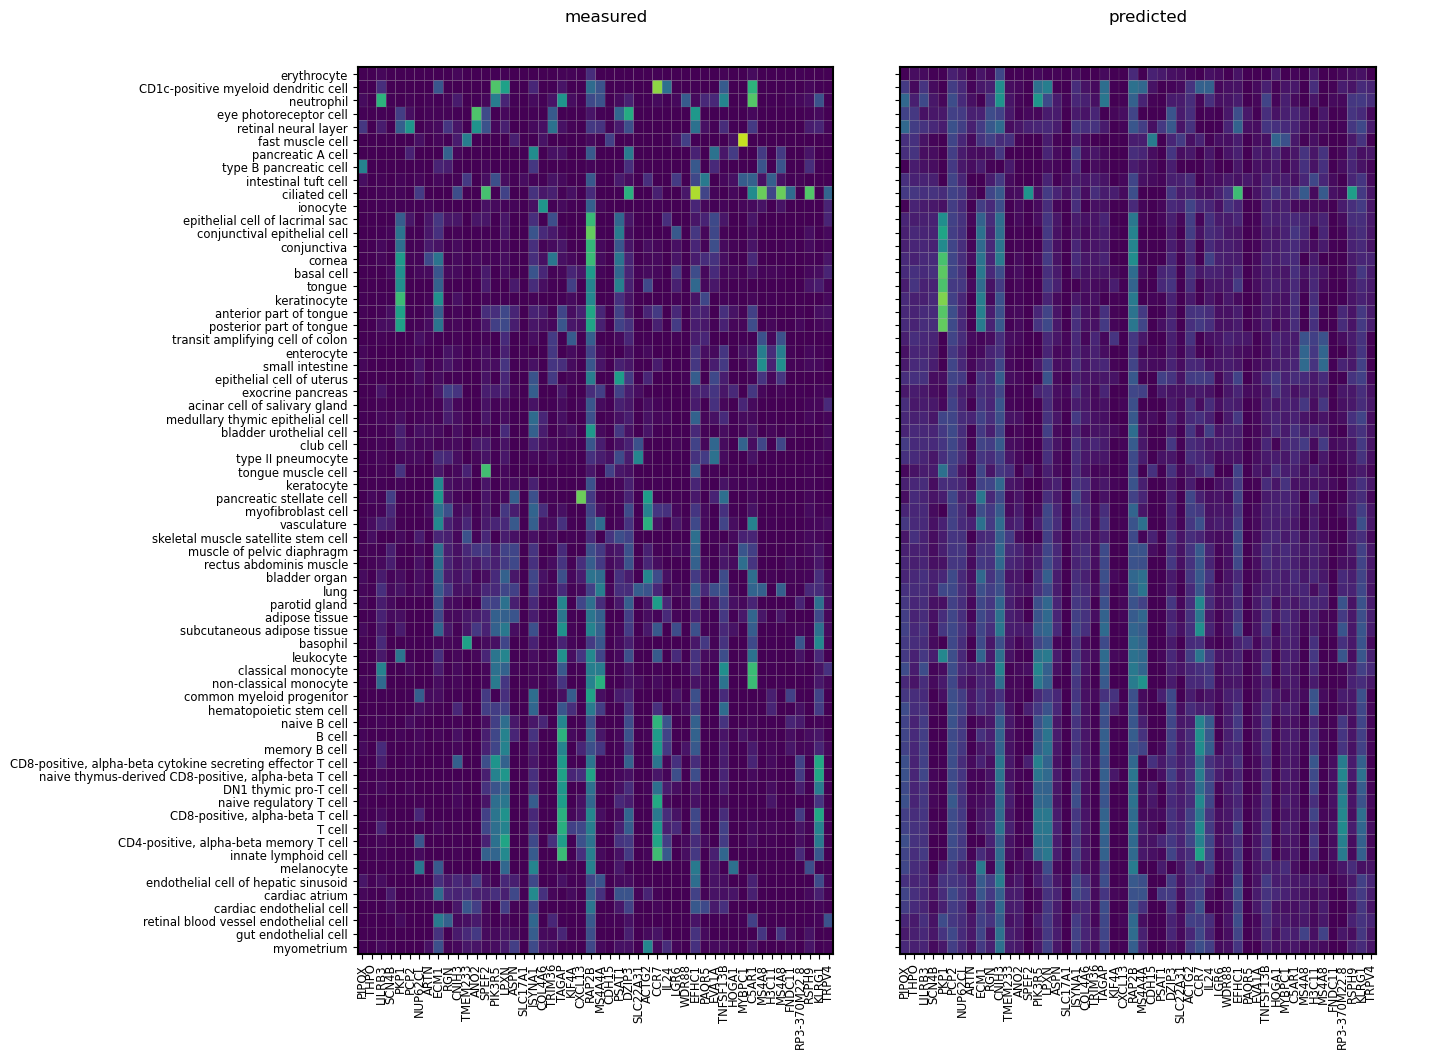

In [5]:
marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc


def plot_marker_gene_heatmap(adata, marker_genes):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 12), gridspec_kw={"wspace": 0})
    sc.pl.matrixplot(
        adata,
        marker_genes,
        groupby="label",
        gene_symbols="feature_name",
        layer=None,
        vmin=0,
        vmax=6,
        ax=ax1,
        show=False,
        title="measured",
        dendrogram=True,
    )
    # fig.axes[-1].remove()
    # fig.axes[-1].remove()
    # fig.axes[-1].remove()
    # if type(marker_genes) is dict:
    #     fig.axes[-1].remove()

    sc.pl.matrixplot(
        adata,
        marker_genes,
        groupby="label",
        gene_symbols="feature_name",
        layer="prediction",
        vmin=0,
        vmax=6,
        ax=ax2,
        show=False,
        title="predicted",
        dendrogram=True,
    )
    # fig.axes[-1].remove()
    # fig.axes[-1].remove()
    # fig.axes[-1].remove()
    # if type(marker_genes) is dict:
    #     fig.axes[-1].remove()
    fig.axes[-1].set_yticklabels([])


def plot_expression_and_correlation(adata, results):
    _, axs = plt.subplots(3, 2, figsize=(14, 13), gridspec_kw={"wspace": 0.2})

    max_expression_val = 6
    # Subplot with expression histograms
    bins = np.linspace(0, max_expression_val, 200)
    axs[0, 0].hist(adata.X.flatten(), bins=bins, density=True)
    axs[0, 0].hist(
        adata.layers["prediction"].flatten(), bins=bins, density=True, alpha=0.5
    )
    axs[0, 0].set_ylim([0, 1])
    axs[0, 0].set_xlim([0, max_expression_val])
    axs[0, 0].set_xlabel("expression")

    # Subplot with expression scatter
    axs[0, 1].plot(
        adata.X.flatten(), adata.layers["prediction"].flatten(), ".", alpha=0.01
    )
    axs[0, 1].plot(
        [0, max_expression_val],
        [0, max_expression_val],
        "k",
        linewidth="2",
        linestyle="--",
    )
    axs[0, 1].set_xlim([0, max_expression_val])
    axs[0, 1].set_ylim([0, max_expression_val])
    axs[0, 1].set_aspect("equal", adjustable="box")
    axs[0, 1].set_xlabel("expression actual")
    axs[0, 1].set_ylabel("expression predicted")

    # Subplot with correlation across genes
    axs[1, 0].hist(
        results["pearsonr_across_genes"], bins=np.linspace(0, 1, 50), density=True
    )
    axs[1, 0].set_xlabel("pearsonr across genes (each data point is a cell)")
    axs[1, 0].set_xlim([0, 1])

    # Subplot with correlation across genes
    axs[1, 1].hist(
        results["pearsonr_across_cells"], bins=np.linspace(0, 1, 100), density=True
    )
    axs[1, 1].set_xlabel("pearsonr across cells (each data point is a gene)")
    axs[1, 1].set_xlim([0, 1])

    # Subplot with correlation vs mean expression for genes
    axs[2, 1].plot(
        adata.X.mean(axis=0), results["pearsonr_across_cells"], ".", alpha=0.1
    )
    axs[2, 1].set_xlabel("mean expression across cells (each data point is a gene)")
    axs[2, 1].set_ylabel("pearsonr across cells")
    axs[2, 1].set_xlim([0, max_expression_val])

    axs[2, 0].set_visible(False)


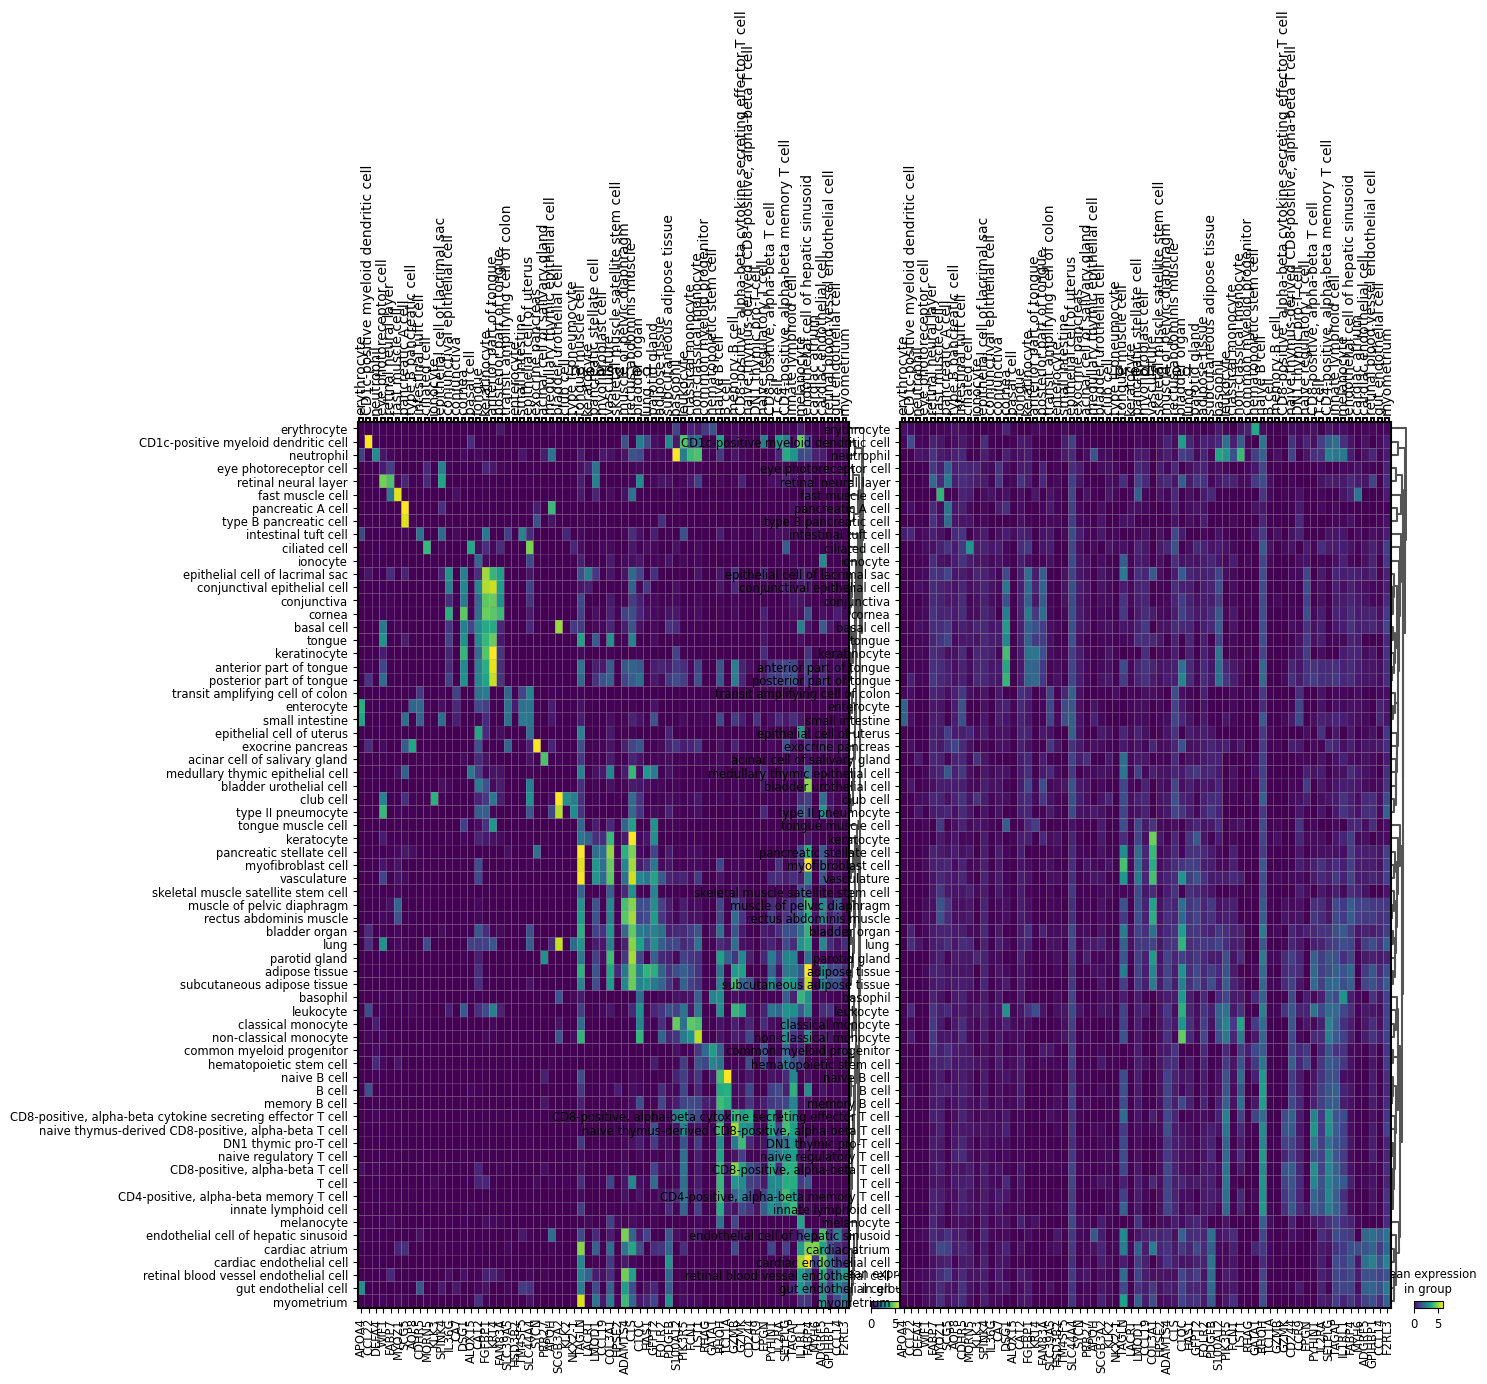

In [53]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)